In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
import time
import math
from queue import PriorityQueue
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['font.serif'] = ['Times new Roman']
plt.rcParams['font.size'] = 10.5
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号


In [ ]:
#plt.subplot()

In [ ]:
def givemedag(v,e,c):
    if e < v-1:
        print('边太少')
        return None
    #e大小要适量
    D = nx.DiGraph()
    leaves=[]
    while(True):
        nx.generators.directed.gn_graph(v-1,kernel = lambda x :x,create_using = D)
        tmp = [x[0] for x in list(D.in_degree()) if x[1] == 0]
        leafnum = len(tmp)
        if D.number_of_edges() + leafnum <= e:
            leaves = tmp.copy()
            break
    #nx.draw(D,with_labels=True)
    
    my_dict = nx.shortest_path_length(nx.reverse_view(D),source=0)
    mylst = list(zip(my_dict.values(), my_dict.keys()))
    #print(my_dict)
    #print(mylst)
    #print(leaves)
    D.add_node(v-1)
    for each in leaves:
        fea = [x[1] for x in mylst if x[0]>my_dict[each]]
        fea.append(v-1)
        D.add_edge(random.choice(fea),each)
    return D.reverse()

In [ ]:
def allocation(dag,agentinfo,timelimit):
    basebid = {}
    relativebid = []
    welfare = 0.0
    for e in list(dag.edges):
        agentinfo[e].sort(key = lambda x:x[1])
        basebid[e] = agentinfo[e][0][0]
        nowbid = basebid[e]
        for i in range(len(agentinfo[e])):
            if i > 0 and agentinfo[e][i][0] > nowbid:
                nowbid = agentinfo[e][i][0]
                relativebid.append((agentinfo[e][i][0]-basebid[e],agentinfo[e][i][1],agentinfo[e][i][2],agentinfo[e][i][3]))
        dag.edges[e[0],e[1]]['weight'] = agentinfo[e][0][1]
        welfare = welfare + agentinfo[e][0][0]
    #print(relativebid)
    #if nx.dag_longest_path_length(dag) > timelimit:
    #    print('mission impossible')
    #    return -1
    vis = {}
    relativebid.sort(key = lambda x:x[0])
    while relativebid != []:
        if len(vis) == dag.number_of_edges():
            break
        item = relativebid.pop()
        if item[2] in vis:
            continue
        tmp = dag.edges[item[2][0],item[2][1]]['weight']
        dag.edges[item[2][0],item[2][1]]['weight'] = item[1]
        if nx.dag_longest_path_length(dag) > timelimit:
            dag.edges[item[2][0],item[2][1]]['weight'] = tmp
            continue
        welfare = welfare + item[0]
        vis[item[2]] = True
    return welfare

In [ ]:
def dfs(dag,ind,agentinfo,timelimit,welfare):
    if ind == dag.number_of_edges():
        if nx.dag_longest_path_length(dag) > timelimit:
            return -1
        return welfare
    te=list(dag.edges)[ind]
    ms = 0.0
    for x in agentinfo[te]:
        dag.edges[te[0],te[1]]['weight'] = x[1]
        ms = max(ms,dfs(dag,ind+1,agentinfo,timelimit,welfare+x[0]))
    return ms

In [ ]:
def brute(dag,agent,timelimit):
    agentinfo = agent.copy()
    for e in list(dag.edges):
        agentinfo[e].sort(key = lambda x:x[1]) 
        filt = [agentinfo[e][i] for i in range(len(agentinfo[e]))if i == 0 or agentinfo[e][i][0] > agentinfo[e][i-1][0]]
        agentinfo[e] = filt
    return dfs(dag,0,agentinfo,timelimit,0)

In [ ]:
def givemeagent(E, C):
    agents = {}
    for e in E:
        ci = np.random.randint(1,C)
        agents[e]=[]
        for i in range(ci):
            bi = -1
            while bi < 0:
                bi = 1*np.random.randn()+50
            ti = -1
            while ti <0:
                ti = np.random.randint(1,100)
            agents[e].append((bi,ti,e,i))
    return agents

In [ ]:
def check(n,C):
    aoe = givemedag(n,1000000000,3)
    assert nx.is_directed_acyclic_graph(aoe)
    #print(aoe.number_of_edges())
    #nx.draw(aoe,with_labels=True)

    es = list(aoe.edges)
    agents = givemeagent(es,C)
    ms = {}
    for e in es:
        agents[e].sort(key = lambda x:x[1])
        nowbid = agents[e][0][0]
        mis = agents[e][0][1]
        mas = agents[e][0][1]
        for i in range(len(agents[e])):
            if i > 0 and agents[e][i][0] > nowbid:
                nowbid = agents[e][i][0]
                mas = agents[e][i][1]
        ms[e] = (mis,mas)
    for e in es:
        aoe.edges[e[0],e[1]]['weight'] = ms[e][0]
    a = nx.dag_longest_path_length(aoe)

    for e in es:
        aoe.edges[e[0],e[1]]['weight'] = ms[e][1]
    b = nx.dag_longest_path_length(aoe)

    tl = np.random.randint(a,b+1)
    
    t0 = time.perf_counter()
    sf = allocation(aoe,agents,tl),
    
    return sf,time.perf_counter()-t0
    #return allocation(aoe,agents,tl),brute(aoe,agents,tl)

In [ ]:
a,b = check(20,3)
print(a,b)

In [ ]:
# exetime.pdf
y = []
x = range(10,10**3)
for u in x:
    print(u)
    c,d = check(u,10)
    y.append(d)
plt.plot(x,y)

In [ ]:
plt.xlabel('aoe网阶数 |V|')
plt.ylabel('算法运行时间 单位(秒)')
plt.plot(x,y,label="贪心分配规则")
plt.legend()
plt.savefig('exetime.pdf')
plt.show()

In [ ]:
df = pd.DataFrame({'x':a,'y':lst})
df.to_csv('exetime10-1000.csv',index=False)

In [ ]:
ndf = pd.read_csv('exetime10-1000.csv')

In [ ]:
plt.xlabel('aoe网阶数 |V|')
plt.ylabel('算法运行时间 （秒）')

plt.plot('x','y','',data = ndf,label='社会福利最大化机制')
plt.legend()

plt.savefig('exetime.pdf')
plt.show()

In [ ]:

testn=[10,15,20]
for x in testn:
    ratiolist = []
    cnt = 0
    for i in range(1000):
        print(i)
        a,b = check(x,3)
        if math.fabs(a-b) < 1e-8:
            cnt=cnt+1
        ratiolist.append(a/b)
        
        #print("a/b=%lf"%(a/b))
    print(cnt,np.median(ratiolist),np.mean(ratiolist),np.std(ratiolist,ddof=1))


In [ ]:
998 1.0 0.9999980277131707 5.478483267317938e-05

994 1.0 0.999998769926064 1.8107295551290027e-05
992 1.0 0.9999979986019756 2.9445272088786218e-05


In [ ]:
print(cnt,np.median(ratiolist),np.mean(ratiolist),np.std(ratiolist,ddof=1))

In [ ]:
len(ratiolist)

In [ ]:
x = range(10,10**3)

In [ ]:
y1 = [i*(5*np.random.randn()+50)for i in x]

In [ ]:
y2 = [i*(5*np.random.randn()+60)for i in x]

In [ ]:
plt.plot(x,y1,label='SW maximization')
plt.plot(x,y2,label='optimal auction')
plt.legend(loc="upper left")

In [ ]:
plt.show()

In [ ]:
def reweight(dag,agentinfo):
    for e in list(dag.edges):
        dag.edges[e[0],e[1]]['weight'] = agentinfo[e][0][1]

In [ ]:
def allocation2(dag,agentinfo,timelimit):
    #basebid = {}
    relativebid = [(agentinfo[e][i][0]-agentinfo[e][0][0],agentinfo[e][i][1],agentinfo[e][i][2],agentinfo[e][i][3])for e in list(dag.edges)for i in range(1,len(agentinfo[e]))]
    #print('#')
    #print(relativebid)
    #print('#')
    ansdict = {}
    reweight(dag,agentinfo)
    for e in list(dag.edges):
        #dag.edges[e[0],e[1]]['weight'] = agentinfo[e][0][1]
        ansdict[e] = 0
    #print(relativebid)
    #if nx.dag_longest_path_length(dag) > timelimit:
    #    print('mission impossible')
    #    return -1
    vis = {}
    relativebid.sort(key = lambda x:x[0])
    while relativebid != []:
        if len(vis) == dag.number_of_edges():
            break
        item = relativebid.pop()
        #print('$')
        #print(item)
        if item[2] in vis:
            continue
        tmp = dag.edges[item[2][0],item[2][1]]['weight']
        dag.edges[item[2][0],item[2][1]]['weight'] = item[1]
        if nx.dag_longest_path_length(dag) > timelimit:
            dag.edges[item[2][0],item[2][1]]['weight'] = tmp
            continue
        vis[item[2]] = True
        #print(e)
        #print(item[3])
        ansdict[item[2]] = item[3]
    return ansdict

In [ ]:
def init(dag,agentinfo):
    for e in list(dag.edges):
        agentinfo[e].sort(key=lambda x:x[0],reverse=True)
        agentinfo[e].sort(key = lambda x:x[1]) 
        nowbid = agentinfo[e][0][0]
        tmp = [(agentinfo[e][0][0],agentinfo[e][0][1],agentinfo[e][0][2],0)]
        for i in range(1,len(agentinfo[e])):
            if agentinfo[e][i][0] > nowbid:
                nowbid = agentinfo[e][i][0]
                lens = len(tmp)
                tmp.append((agentinfo[e][i][0],agentinfo[e][i][1],agentinfo[e][i][2],lens))
        agentinfo[e] = tmp

In [ ]:
def graphseq(dag,agentinfo,e,ind,relativebid,timelimit):
    reweight(dag,agentinfo)
    #cong tou qu 
    relativebid.sort(key = lambda x:x[0])
    vis = {}
    if ind > 0:
        sign = False
        addon = agentinfo[e][ind-1][0]-agentinfo[e][0][0]
        
        while relativebid != []:
            item = relativebid.pop()
            if item[2] in vis:
                continue
            if item[2] == e:
                if item[0] <= addon:
                    break
                else:
                    if item[3] == ind:
                        sign=True
                    continue
            tmp = dag.edges[item[2][0],item[2][1]]['weight']
            dag.edges[item[2][0],item[2][1]]['weight'] = item[1]
            if nx.dag_longest_path_length(dag) > timelimit:
                dag.edges[item[2][0],item[2][1]]['weight'] = tmp
                continue
            vis[item[2]] = True
            if sign:
                dag.edges[e[0],e[1]]['weight'] = agentinfo[e][ind][1]
                if nx.dag_longest_path_length(dag) > timelimit:
                    addon = max(addon,item[0])
                    break
                dag.edges[e[0],e[1]]['weight'] = agentinfo[e][0][1]
        #print(e,1,addon+agentinfo[e][0][0])
        return addon+agentinfo[e][0][0]
    else:
        if len(agentinfo[e]) == 1:
            #print(e,0,0)
            return 0
        graphs=[dag.copy()]
        bids=[0]
        que = PriorityQueue()
        while relativebid != []:
            item = relativebid.pop()
            if item[0] < agentinfo[e][1][0]:
                break
            if item[2] in vis:
                continue
            if item[2] == e:
                pre = len(bids)-1
                if pre > 0:
                    que.put((bids[pre]-item[0],pre,item[3]))
                continue
            tmp = dag.edges[item[2][0],item[2][1]]['weight']
            dag.edges[item[2][0],item[2][1]]['weight'] = item[1]
            if nx.dag_longest_path_length(dag) > timelimit:
                dag.edges[item[2][0],item[2][1]]['weight'] = tmp
                continue
            vis[item[2]] = True
            graphs.append(dag.copy())
            bids.append(item[0])
        acc = 0 #crucial
        addons = -1
        while not que.empty():
            front = que.get()
            if front[1] >= 1:
                delta = bids[front[1]]-(agentinfo[e][front[2]][0] + acc)
                acc = acc + delta
                if acc >= agentinfo[e][0][0]:
                    break
                newdist = max(0,bids[front[1]-1]-bids[front[1]])+ delta
                que.put((newdist,front[1]-1,front[2]))
            prepos = front[1]
            myind = front[2]
            graphs[prepos].edges[e[0],e[1]]['weight'] = agentinfo[e][myind][1]
            if nx.dag_longest_path_length(graphs[prepos]) <= timelimit: 
                addons = bids[prepos+1]-agentinfo[e][myind][0]
                break
            graphs[prepos].edges[e[0],e[1]]['weight'] = agentinfo[e][0][1]
        if addons == -1:
            #print(e,0,0)
            return 0
        #print(e,0,agentinfo[e][0][0]-addons)
        return agentinfo[e][0][0]-addons

In [ ]:
def payment(dag,agentinfo,timelimit):
    
    relativebid = [(agentinfo[e][i][0]-agentinfo[e][0][0],agentinfo[e][i][1],agentinfo[e][i][2],agentinfo[e][i][3])for e in list(dag.edges)for i in range(1,len(agentinfo[e]))]
    allo = allocation2(dag,agentinfo,timelimit)
    #print(allo)
    ans = 0.0
    for e in list(dag.edges):
        ans = ans + graphseq(dag,agentinfo,e,allo[e],relativebid,timelimit)
    #print(ans)
    return ans

In [ ]:
def checkpay(n,C):
    #n=200
    #C=3
    aoe = givemedag(n,1000000000,3)
    assert nx.is_directed_acyclic_graph(aoe)
    #print(aoe.number_of_edges())
    #nx.draw(aoe,with_labels=True)
    es = list(aoe.edges)
    agents = givemeagent(es,C)
    init(aoe,agents)
    #print(agents)
    ms = {}
    for e in es:
        ms[e] = (agents[e][0][1],agents[e][len(agents[e])-1][1])
    for e in es:
        aoe.edges[e[0],e[1]]['weight'] = ms[e][0]
    a = nx.dag_longest_path_length(aoe)

    for e in es:
        aoe.edges[e[0],e[1]]['weight'] = ms[e][1]
    b = nx.dag_longest_path_length(aoe)
    #print(a,b)
    tl = np.random.randint(a,b+1)
    #payment(aoe,agents,tl)
    return payment(aoe,agents,tl)


In [ ]:
#print(tl)
#payment(aoe,agents,tl)

In [ ]:
#allo = allocation2(aoe,agents,tl)

In [ ]:
#print(allo)

In [ ]:
checkpay(1000,100)

In [ ]:
y = []
x = range(10,200)
for u in x:
    print(u)
    y.append(checkpay(u,100))
#y=[checkpay(u,100)for u in x]

plt.plot(x,y)

In [ ]:
plt.xlabel('$|V|$')
plt.ylabel('revenue')

plt.plot(x,y,label="SW Maximization")
#plt.plot(x,y2,label="optimal auction")
plt.legend()
#plt.savefig('revenuevsv.pdf')
plt.show()

In [ ]:
y2=[]
for u in y:
    up = np.random.randint(1,11)
    if up >= 3:
        y2.append(u*(1+np.random.randint(10,20)*0.01))
    else:
        y2.append(u*(1-np.random.randint(1,10)*0.01))


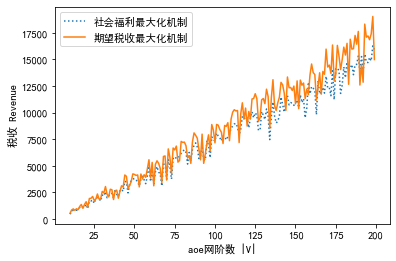

In [13]:
plt.xlabel('aoe网阶数 |V|')
plt.ylabel('税收 Revenue')

plt.plot(x,y,label="社会福利最大化机制",linestyle=':')
plt.plot(x,y2,label="期望税收最大化机制")
plt.legend()
plt.savefig('SWandoptimal.pdf')
plt.show()

In [12]:
df = pd.DataFrame({'x':x,'y':y})
df.to_csv('SWandOptimal_sw.csv',index=False)

df = pd.DataFrame({'x':x,'y':y2})
df.to_csv('SWandOptimal_opt.csv',index=False)

In [ ]:
x = range(10,1000)
yz=[]
for u in y:
    if len(yz) == 990:
        break
    a = u/8000
    yz.append(a)
    for k in range(5):
        if len(yz) == 990:
            break
        yz.append(np.random.normal(a))

y1 = [np.random.normal(float(u**2),scale = 1e4)/1e8 for u in x]
y2 = [np.random.normal(float(u)/2*1e8,scale = 1e5)/1e8 for u in x]
y3 = [np.random.normal(1e10+float(u)/2*1e8,scale = 1e3)/1e8 for u in x]
#for u in yz:
 #   u*np.random.normal

plt.xlabel('$n$')
plt.ylabel('time in secs')

plt.plot(x,y1,label="greedy")
plt.plot(x,y2,label="multi index")
plt.plot(x,y3,label="orgs extension")

plt.legend()
plt.savefig('greedytimes.pdf')
#plt.show()

In [ ]:
plt.xlabel('参与者的数量 （个）')
plt.ylabel('参与者k的效用 $utility_k$')
x = [10,100,200,300,400,500]
y1=[63.1,57.332,18.654,17.98,0,0]
plt.scatter(x,y1,label="$utility_k$",marker='x')
#plt.plot(x,y2,label = "multi index")
#plt.plot(x,y3,label = "orgs extension")
plt.legend()
plt.savefig('utility.pdf')
#plt.show()

In [ ]:
plt.xlabel('$|V|$')
plt.ylabel('execution time in seconds')
plt.plot(x,y,label="SW maximization")

plt.savefig('exetime.pdf')
plt.show()

In [ ]:
def newtons(f,df,x0,e):
    xn = float(x0)
    e_tmp = e+1
    loop = 1
    while e_tmp>e:
        print '########loop'+str(loop)
        k = df(xn)
        xm = f(xn)
        print 'xn='+str(xn)+',k='+str(k)+',y='+str(xm)
        q = xm/k
        xn = xn-q
        e_tmp = abs(0-f(xn))
        print 'new xn='+str(xn)+',e='+str(e_tmp)+',q='+str(q)
        loop=loop+1
    return xn  

In [ ]:
x = np.linspace(0,2,200)
z = np.zeros(100)
o = np.ones(100)
y = np.concatenate([z,o])
plt.xlabel('z')
plt.ylabel('x(z)')
plt.xticks([])
plt.plot(x,y)
plt.savefig('jieyuefenpei.pdf')
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1)
from scipy.stats import norm
x = np.linspace(norm.ppf(0.001),
                norm.ppf(0.999), 100)
ax.plot(x, x-(1-norm.cdf(x)/norm.pdf(x)),
       'r-', lw=5, alpha=0.6, label='norm pdf')